In [10]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [11]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter
from datetime import datetime

In [12]:
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

import matplotlib

import matplotlib.font_manager as fm 
fm._rebuild() 

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

# Concatenating Title and Description

In [13]:
# 키워드: 춘천, 기간: 1일
url = "https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds=&de=&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start=1&refresh_start=0"

raw = requests.get(url)
html = raw.content
soup = bs(html,'html.parser')

In [16]:
last = False
page_num = 1
href_list = []
TitDesc_list = []

while last == False:
  raw_url = requests.get("https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds=&de=&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start="+str(page_num)+"&refresh_start=0")
  html = raw_url.content
  soup = bs(html, 'html.parser')

  # 주소 가져오기
  ul = soup.find('ul', {'class' : 'type01'})
  li_list = ul.findAll('li')

  # 검색 시 연관 뉴스는 제외시킴
  for li in li_list:
    try:
      href_list.append(li.dl.dt.a['href'])   # 주소 추가

      d_list = li.findAll('dd')    # 자식 노드 dd가 두 개인데 두 번째 노드에 description이 들어가있으므로 전부 불러온 후 인덱싱할 것임

      title = li.dl.dt.a['title']
      description = d_list[1].text    # 자식 노드 dd의 두 번째에 들어가 있는 description을 text로 불러옴

      TitDesc_list.append( title + ' ' + description)
    except AttributeError:
      pass

  # 마지막 페이지 주소 확인 (다음페이지 버튼이 없으면 종료페이지로 간주)
  page = soup.find('div', {'class':'paging'})
  page_a_list = page.findAll('a')
  if '다음페이지' in str(page_a_list[-1]):
    page_num += 10
  else:
    last = True

In [34]:
len(TitDesc_list)

394

In [18]:
TitDesc_okt = []

for item in TitDesc_list:
  item_nouns = ' '.join(okt.nouns(item))
  TitDesc_okt.append(item_nouns)

  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix_okt = tfidf_vectorizer.fit_transform(TitDesc_okt)

#Vectorization

In [19]:
noun_list = []
for i in range(len(TitDesc_okt)):
  for j in range(len(TitDesc_okt[i].split(' '))):
    if len(TitDesc_okt[i].split(' ')[j]) > 1:   # 한 글자 명사 제외
      noun_list.append(TitDesc_okt[i].split(' ')[j])

noun_list = [v for v in noun_list if v]  #리스트 내 공백 제거

counts = Counter(noun_list)

# 명사 추출 및 명사의 빈도수 계산

print('명사 빈도수 : ')
print(counts)

명사 빈도수 : 
Counter({'춘천': 530, '서울': 212, '기온': 191, '강원': 154, '제주': 116, '강릉': 114, '날씨': 106, '대전': 106, '최고': 102, '오후': 93, '오늘': 87, '대구': 85, '지역': 84, '전국': 84, '인천': 81, '춘천시': 74, '광주': 73, '강원도': 69, '폭염': 68, '홍천': 66, '전주': 65, '부산': 60, '무더위': 59, '구름': 57, '수원': 57, '청주': 56, '내일': 54, '주의보': 52, '현재': 48, '남부': 46, '도로': 46, '사업': 43, '병원': 43, '장맛비': 42, '선정': 40, '한낮': 39, '소나기': 38, '코로나': 38, '오전': 37, '운영': 36, '영서': 36, '제주도': 36, '내륙': 36, '경기': 34, '성심': 34, '관리': 33, '삼척': 32, '한림대': 32, '지원': 29, '가운데': 29, '어제': 29, '더위': 28, '발효': 28, '김현철': 28, '위해': 27, '일부': 27, '최저': 27, '지역별': 27, '이번': 26, '남해안': 26, '지방': 26, '원주': 26, '평지': 26, '연구소': 25, '아침': 25, '기상청': 25, '센터': 24, '자전거': 24, '브리': 24, '노인': 23, '대부분': 23, '캠퍼스': 23, '학생': 23, '활동': 23, '시작': 22, '사회': 22, '맑음': 22, '중인': 21, '연구': 21, '올해': 21, '이상': 21, '농촌': 20, '중심': 20, '공단': 20, '안전': 19, '이은형': 19, '재활': 19, '체험': 18, '잣나무': 18, '재선충': 18, '예상': 18, '마을': 17, '프로그램': 17, '이닝': 17, '건보': 17,

In [35]:
tfidf_matrix_okt.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18254566, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

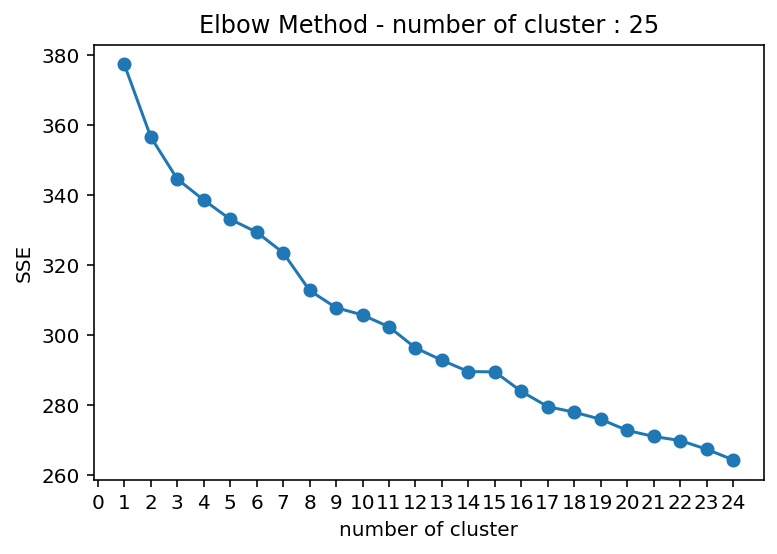

In [27]:
x = normalize(tfidf_matrix_okt)
# L2 정규화

def elbow(normalizedData, Clusters):
  sse = []
  for i in range(1,Clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(normalizedData)
    sse.append(kmeans.inertia_)

  plt.plot(range(1,Clusters), sse, marker='o')
  plt.xlabel('number of cluster')
  plt.xticks(np.arange(0,Clusters,1))
  plt.ylabel('SSE')
  plt.title('Elbow Method - number of cluster : '+str(Clusters))
  plt.show()
elbow(x, 25)

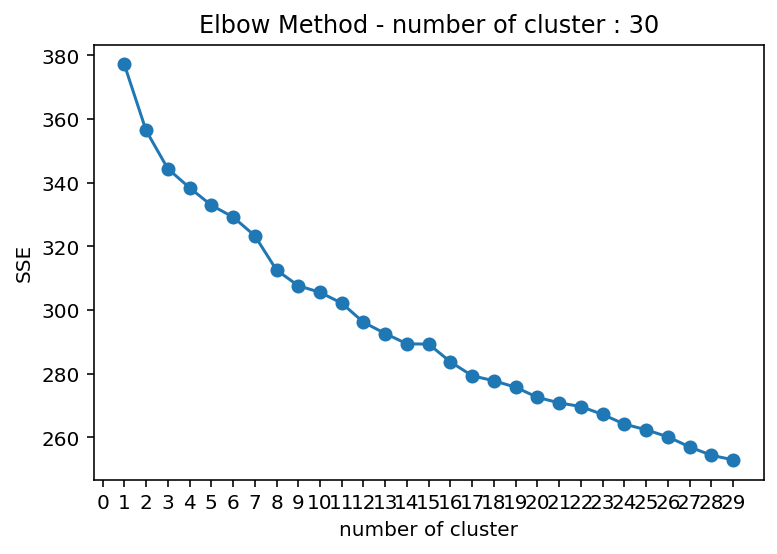

In [28]:
elbow(x, 30)

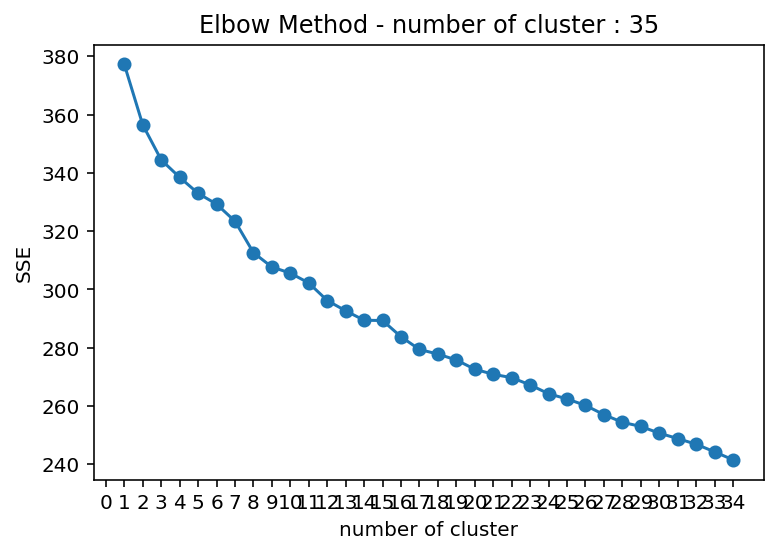

In [29]:
elbow(x,35)

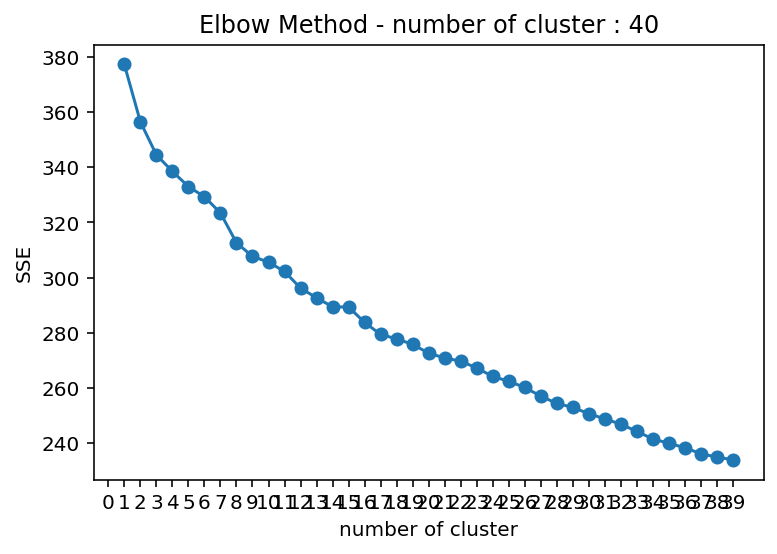

In [30]:
elbow(x,40)

In [31]:
clusters_num = 15
kmeans = KMeans(n_clusters = clusters_num).fit(x)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [32]:
df = pd.DataFrame(data=TitDesc_okt)
df.columns = ["title"]
df['num']=0
for i in range(len(df)):
  df.iloc[i, 1] = i

df['labels'] = labels
# 클러스터링 라벨 부여
df.head(3)

,title,num,labels
0,시민 안전 위해 더 촘촘하 춘천시 신규 설치 특별 교부 세 시비 등 투입 노후 대도 교체 강원 춘천시 보행자 안전 위해 현재 춘천 지역 총 곳 대의 운영 중이 방범 용 어린이 보호 용,0,2
1,장덕 범 홍 숙 춘천 제 호 부부 탄생 지혜 안전 기부 약속 홍경숙 지혜 안전 대표 남편 장덕 범 씨 춘천 지역 제 호 부부 소사이어티 이하 너 회원 홍 대표 춘천 시청 이재수 춘천시 유계,1,2
2,춘천 전국 첫 동물 마을 펫팸 타운 조성 강원 춘천시 전국 처음 반려동물 살 수 전원주택 펫팸 타운 조성 반려동물 산업 확산 춘천시 반려동물 사람 마음 수 건물 방 배치,2,2


In [33]:
for i in range(clusters_num):
  print('<<Clustering Label {0}>>'.format(i)+'\n')
  print(df.loc[df['labels']==i])

<<Clustering Label 0>>

                                                                                                                                 title  ...  labels
77   한림대학교의료원 급성 뇌졸중 적정 평가 획득 이번 평가 한림대의료원 병원 한림대 성심 병원 한림대 강남 성심 병원 한림대 춘천 성심 병원 한림대 성심 병원 한림대 춘천 성심 병원 연속 한림대 강남 성심 병원 한림대 동탄성심병원 연속  ...       0
92   한림대의료원 마이크로 바이옴 간질 환 치료 기술 연구 선도 한림대 춘천 성심 병원 김동준 교수 현재 소화기 연구소 마이크로 바이옴 연구 후부 치료 물질 도출 한림대 춘천 성심 병원 기태 교수 우리 소화기 연구소 올해 락토바실러스 균  ...       0
116  한림대학교의료원 급성 뇌졸중 적정 평가 획득 이번 평가 한림대의료원 병원 한림대 성심 병원 한림대 강남 성심 병원 한림대 춘천 성심 병원 한림대 성심 병원 한림대 춘천 성심 병원 연속 한림대 강남 성심 병원 한림대 동탄성심병원 연속  ...       0
153  한림대의료원 급성 뇌졸중 적정 평가 최우수 등급 획득 한림대 학교 성심 병원 한림대 학교 강남 성심 병원 한림대 학교 춘천 성심 병원 점 만점 점 한편 이번 적정 평가 결과 한림대 학교 성심 병원 한림대 학교 춘천 성심 병원 ...  ...       0
154  한림대의료원 마이크로 바이옴 간질 환 치료 기술 연구 선도 한림대 춘천 성심 병원 김동준 교수 현재 소화기 연구소 마이크로 바이옴 연구 후부 치료 물질 도출 한림대 춘천 성심 병원 기태 교수 우리 소화기 연구소 올해 락토바실러스 균  ...       0
208  한림대의료원 마이크로 바이옴 간질 환 치료 기술 연구 선도 한림대 춘천 성심 병원 김동준 교수 현재 소화기 연구소 마이크로 바이옴 연구 후부 치료 물